In [1]:
import pandas as pd

# Load the data
file_path = 'gbif_data.csv'
df = pd.read_csv(file_path)

# Step 1: Remove duplicates
df = df.drop_duplicates()

# Step 2: Handle missing values
df = df.dropna(subset=['decimalLatitude', 'decimalLongitude', 'eventDate'])

# Step 3: Normalize date-time
df['eventDate'] = pd.to_datetime(df['eventDate'], errors='coerce')
df = df.dropna(subset=['eventDate'])  # Drop rows with invalid dates

# Create new time-based columns
df['year'] = df['eventDate'].dt.year
df['month'] = df['eventDate'].dt.month
df['day'] = df['eventDate'].dt.day
df['hour'] = df['eventDate'].dt.hour
df['minute'] = df['eventDate'].dt.minute
df['second'] = df['eventDate'].dt.second

# Step 4: Remove invalid coordinates
df = df[(df['decimalLatitude'].between(-90, 90)) & (df['decimalLongitude'].between(-180, 180))]

# Save cleaned data
cleaned_file = 'gbif_data_cleaned.csv'
df.to_csv(cleaned_file, index=False)

print(f"Cleaned data saved to '{cleaned_file}' with {len(df)} records.")


Cleaned data saved to 'gbif_data_cleaned.csv' with 21054 records.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
file_path = 'gbif_data_cleaned.csv'
df = pd.read_csv(file_path)

# 1. Most Common Species
top_species = df['scientificName'].value_counts().head(10)
print("\nTop 10 Most Observed Species:")
print(top_species)



Top 10 Most Observed Species:
scientificName
Axis axis (Erxleben, 1777)                         1375
Macaca radiata (É.Geoffroy Saint-Hilaire, 1812)     996
Funambulus pennantii Wroughton, 1905                951
Macaca mulatta (Zimmermann, 1780)                   894
Panthera tigris tigris                              887
Boselaphus tragocamelus (Pallas, 1766)              758
Semnopithecus entellus (Dufresne, 1797)             728
Elephas maximus indicus Cuvier, 1798                693
Ratufa indica (Erxleben, 1777)                      683
Pteropus giganteus (Brünnich, 1782)                 661
Name: count, dtype: int64


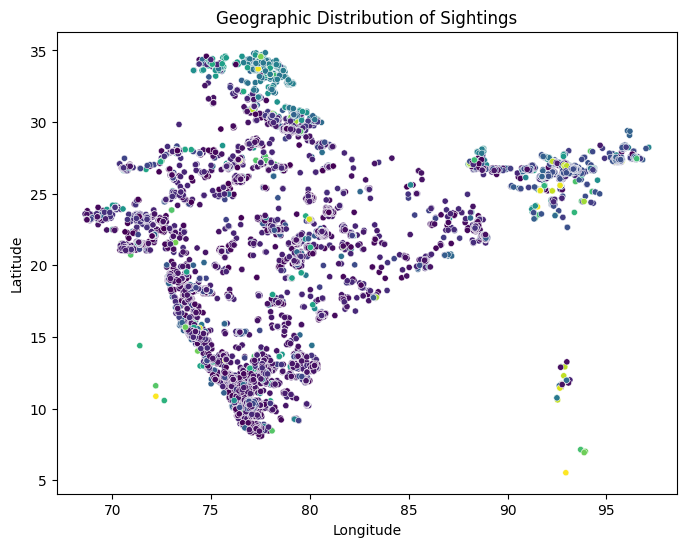

In [7]:
# 2. Geographic Distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='decimalLongitude', y='decimalLatitude',
                hue='scientificName', palette='viridis', legend=False, s=20)
plt.title('Geographic Distribution of Sightings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

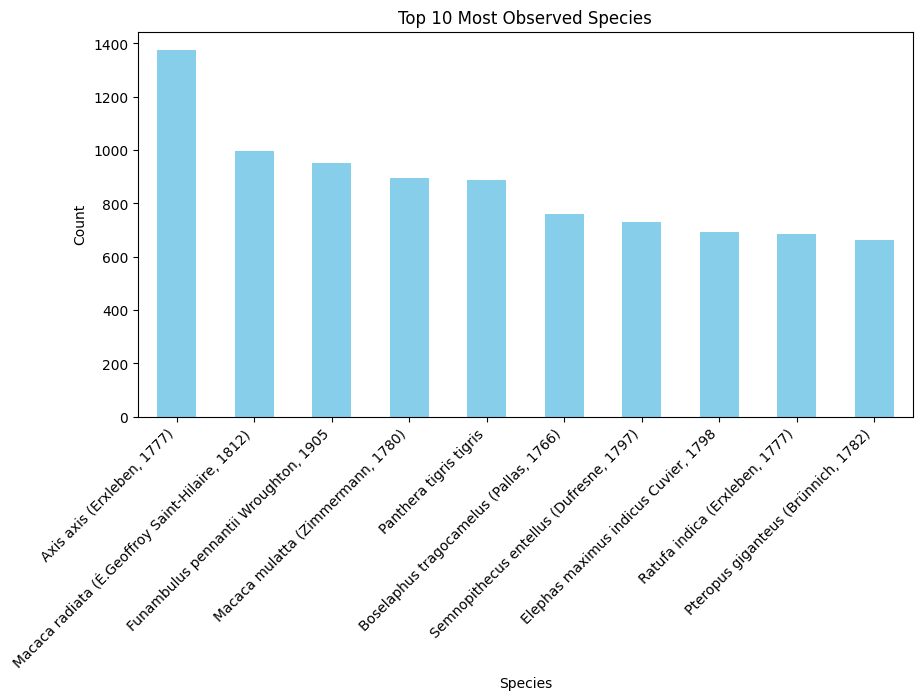

In [8]:
# Plot top species
plt.figure(figsize=(10, 5))
top_species.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Observed Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

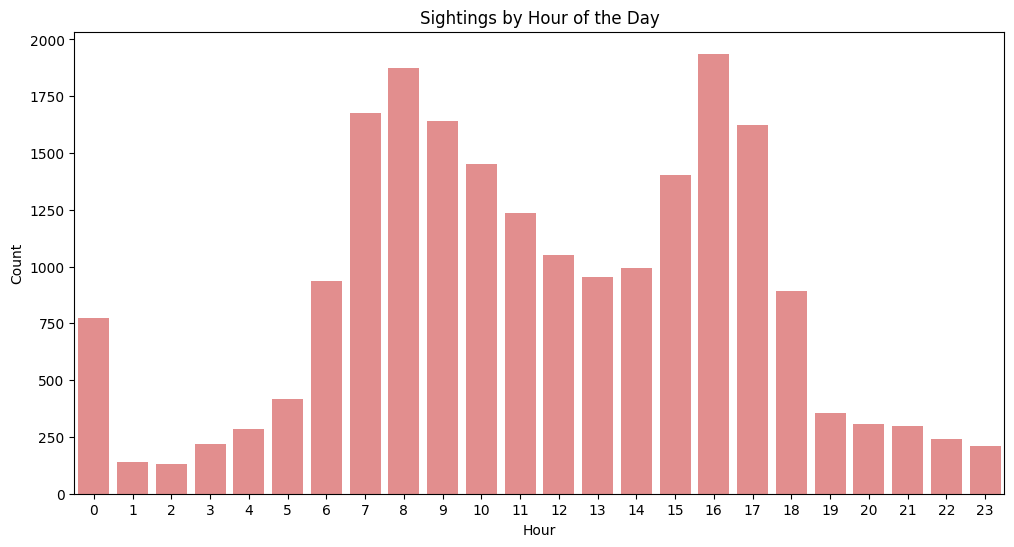

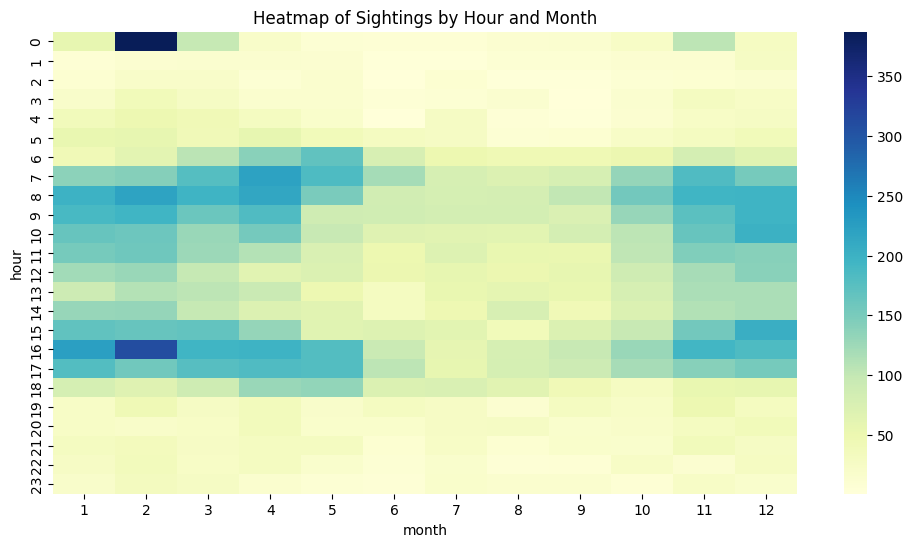

In [9]:
# 3. Time-Based Analysis
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour', color='lightcoral')
plt.title('Sightings by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot_table(index='hour', columns='month',
            values='scientificName', aggfunc='count', fill_value=0), cmap='YlGnBu')
plt.title('Heatmap of Sightings by Hour and Month')
plt.show()

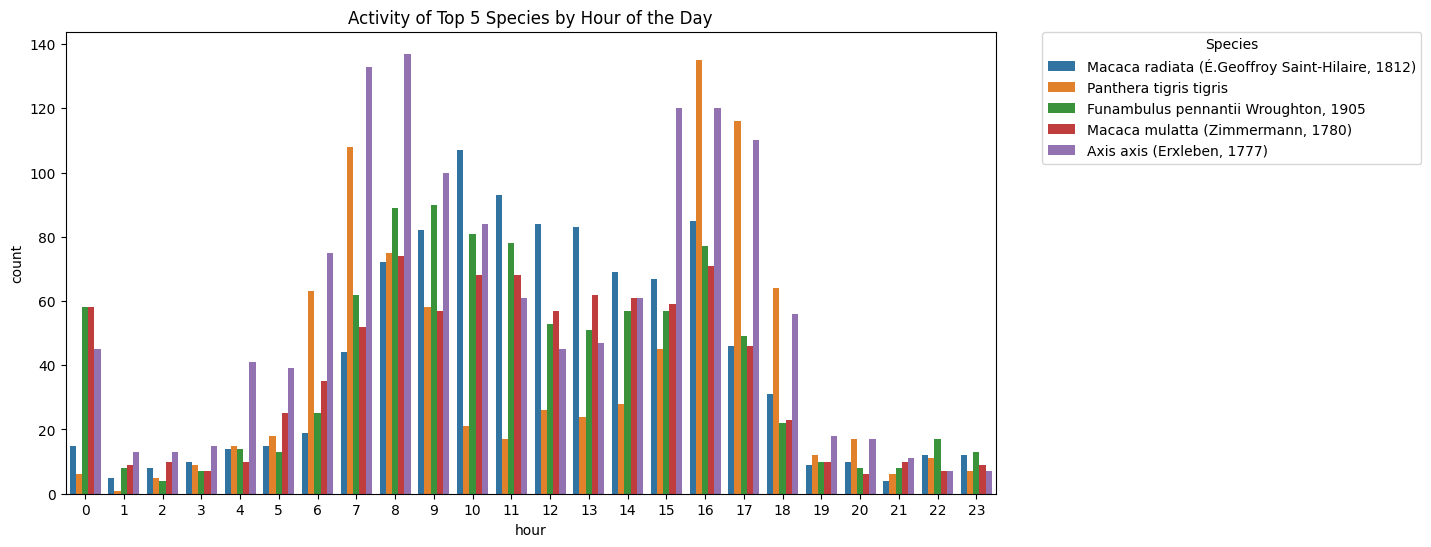

In [13]:
# Top 5 most observed species
top_5_species = df['scientificName'].value_counts().head(5).index
filtered_df = df[df['scientificName'].isin(top_5_species)]

# Species vs. Time of Day (Limited to Top 5)
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='hour',
              hue='scientificName', palette='tab10')
plt.title('Activity of Top 5 Species by Hour of the Day')
plt.legend(title='Species', bbox_to_anchor=(
    1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

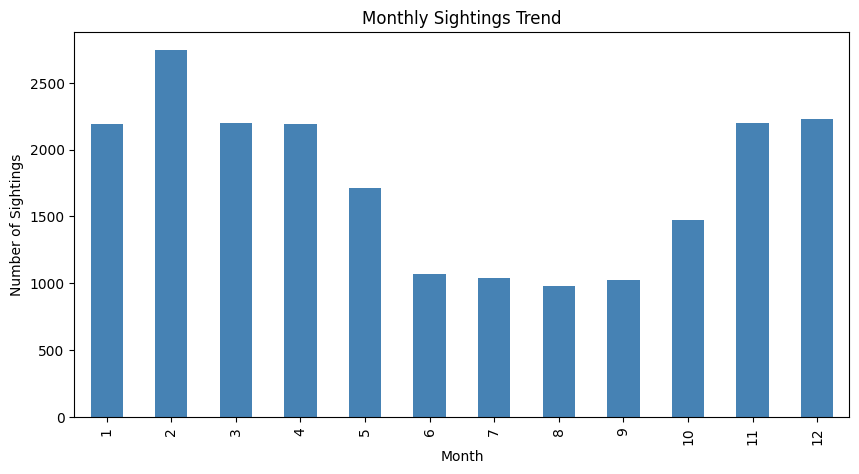

In [14]:
monthly_trend = df.groupby('month')['scientificName'].count()
plt.figure(figsize=(10, 5))
monthly_trend.plot(kind='bar', color='steelblue')
plt.title('Monthly Sightings Trend')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.show()

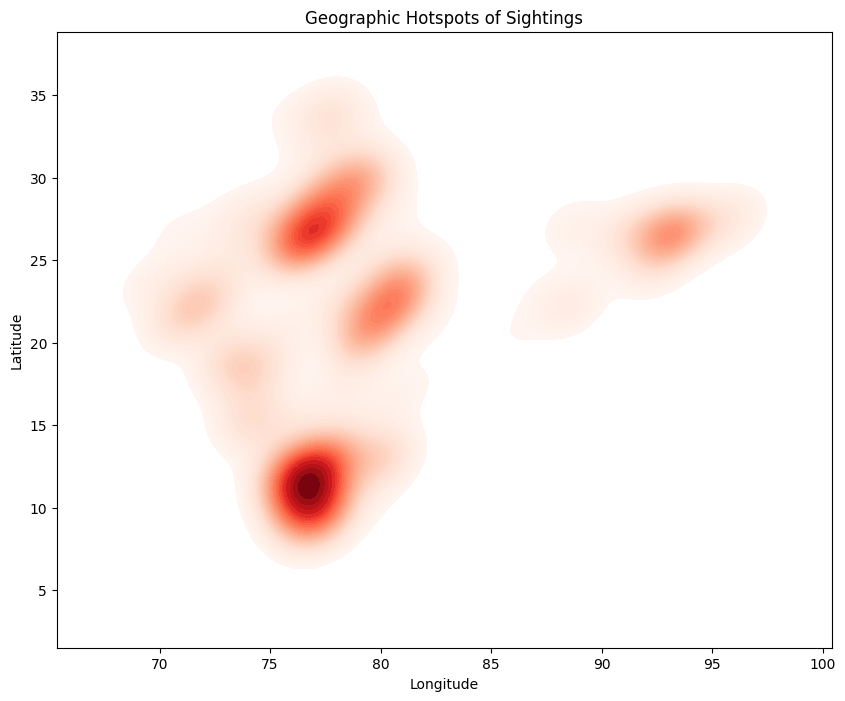

In [15]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df, x='decimalLongitude', y='decimalLatitude',
            fill=True, cmap='Reds', thresh=0.05, levels=50)
plt.title('Geographic Hotspots of Sightings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [29]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point

# ✅ Load Wildlife Data
file_path = 'gbif_data.csv'  # Update with actual path if different
df = pd.read_csv(file_path)

# ✅ Filter Wildlife Data for Karnataka
karnataka = df[(df['decimalLatitude'] >= 11.0) & (df['decimalLatitude'] <= 15.0) &
               (df['decimalLongitude'] >= 74.0) & (df['decimalLongitude'] <= 78.0)]

print(f"Filtered {len(karnataka)} records for Karnataka.")

# ✅ Define Bounding Box for Karnataka
north, south, east, west = 15.0, 11.0, 78.0, 74.0

# ✅ Get Road Network from OpenStreetMap
print("Fetching road network for Karnataka...")
bbox = (north, south, east, west)
G = ox.graph_from_bbox(bbox, network_type='drive')

# ✅ Convert Road Network to GeoDataFrame
edges = ox.graph_to_gdfs(G, nodes=False)
print(f"Loaded road network with {len(edges)} edges.")

# ✅ Convert Wildlife Data to GeoDataFrame
gdf_wildlife = gpd.GeoDataFrame(
    karnataka,
    geometry=gpd.points_from_xy(
        karnataka['decimalLongitude'], karnataka['decimalLatitude']),
    crs="EPSG:4326"
)

# ✅ Perform Nearest Spatial Join (Find Closest Road)
print("Finding nearest roads to wildlife sightings...")
nearest_road = gpd.sjoin_nearest(
    gdf_wildlife, edges, how="left", distance_col="distance_to_road"
)

# ✅ Select Relevant Fields
nearest_road = nearest_road[['scientificName', 'decimalLatitude',
                             'decimalLongitude', 'distance_to_road', 'highway', 'length']]

# ✅ Save Merged Data to CSV
output_file = 'karnataka_wildlife_traffic.csv'
nearest_road.to_csv(output_file, index=False)
print(
    f"Merged data saved to '{output_file}' with {len(nearest_road)} records.")

Filtered 6668 records for Karnataka.
Fetching road network for Karnataka...


c:\Python311\Lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 12,806 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


KeyboardInterrupt: 